# 相关系数法影像匹配

## 流程图

![影响匹配流程图](https://img.imgdb.cn/item/605569ef524f85ce29996ed9.png)

## 相关系数的计算
$$\rho=\frac{S_{gg'}-S_g \cdot S_{g'}/N}{\sqrt{(S_{gg}-S_g^2/N)(S_{g'g'}S^2_{g'}/N)}}$$

$S_g$ 是模板图像的每个像素的灰度值之和
$S_{g'}$是窗口图像的每个像素的灰度值之和

$S_{gg}$是模板图像与自身的每个像素的点积之和

$S_{g'g'}$是窗口图像与自身的每个像素的点积之和

$S_{gg'}$是模板图像与窗口图像的每个像素的点积之和

假设模板图像$g$为$\begin{pmatrix}1 & 2 & 3\\\ 4 & 5 & 6\\\ 7 & 8 & 9 \end{pmatrix}$，某个窗口图像$g'$为$\begin{pmatrix}1 & 8 & 5\\\ 7 & 4 & 2\\\ 3 & 1 & 6 \end{pmatrix}$
则

$S_g=1+2+3+4+5+6+7+8+9=45$

$S_{g'}=1+8+5+7+4+2+3+1+6=37$

$S_{gg}=1\times 1+8\times 8+5\times 5+7\times 7+4\times 4+2\times 2+3\times 3+1\times 1+6\times 6=175$

$S_{g'g'}=1\times 1+2\times 2+3\times 3+4\times 4+5\times 5+6\times 6+7\times 7+8\times 8+9\times 9=285$

$S_{gg'}=1\times 1+2\times 8+3\times 5+4\times 7+5\times 4+6\times 2+7\times 3+8\times 1+9\times 6=175$

In [1]:
import numpy as np
def get_correlation(match_window_image, template_image):
    sggp = np.sum(np.multiply(match_window_image, template_image))
    sgg = np.sum(np.multiply(template_image, template_image))
    sgpgp = np.sum(np.multiply(match_window_image, match_window_image))
    sg = np.sum(template_image)
    sgp = np.sum(match_window_image)
    n = template_image.size
    a = sggp - sg * sgp / n
    b = sgg - sg * sg / n
    c = sgpgp - sgp * sgp / n
    p = a / np.sqrt(b * c)
    return p

## 计算模板图像与匹配图像上每个窗口之间的相关系数

In [2]:
def do_match_image(match_image, template_image, search_area=None):
    """
    在搜索区域中进行逐窗口的相关系数计算
    @ matchImage: 大图,在这张图上进行匹配
    @ templateImage: 小图,模板图像
    @ searchArea: 搜索区域,默认是全图
    @ return：匹配位置的左上角坐标
    """
    # 如果未指定搜索区域，则搜索区域为待匹配影像全图
    if search_area is None:
        search_area = (0, 0, match_image.shape[1], match_image.shape[0])
    # 搜索区域大小
    search_area_width = search_area[2]
    search_area_height = search_area[3]
    # 模板大小
    template_image_height = template_image.shape[0]
    template_image_width = template_image.shape[1]
    # 遍历搜索区域，计算每个窗口与模板图像的相关系数
    correlations = []  # 每个窗口与模板图像的相关系数都存在这个数组中
    for y in range(search_area_height - template_image_height + 1):
        for x in range(search_area_width - template_image_width + 1):
            left_up_x = search_area[0] + x
            left_up_y = search_area[1] + y
            match_window_image = match_image[left_up_y:left_up_y + template_image_height,
                                             left_up_x:left_up_x + template_image_width]
            correlations.append(get_correlation(
                match_window_image, template_image))

    # 由相关系数最大值的位置计算匹配位置的左上角坐标
    max_location = np.argmax(correlations)
    matched_up_left_x = search_area[0] + \
        max_location % (search_area_width - template_image_width + 1)
    matched_up_left_y = search_area[1] + max_location / \
        (search_area_width - template_image_width + 1)
    matched_up_left = (int(matched_up_left_x), int(matched_up_left_y))
    # 返回坐标
    return matched_up_left

在`do_match_image`中我们传入了三个参数，分别是待匹配的大图`match_image`、模板图像`template_image`和搜索区域`search_area`.

其中待匹配图像需要是单波段的灰度图像，这个可以在传入之前用opencv的`cvtColor`进行转换。
模板图像也是单波段的灰度图像，处理方式同待匹配图像。
搜索区域如果未指定（即为默认值None），则认为是在`match_image`全图中进行主窗口匹配

> opencv中的矩形`rectangle`有两种定义方式，一种是指定左上角点与右下角点的坐标，另一种方式是指定左上角点坐标与宽度和长度，本程序采用第二种。

两个嵌套的`for`实现的是从匹配图像上，依据模板图像的大小，按照行的方向裁取窗口图像，并将其与模板图像进行相关系数的计算，并将计算得到的相关系数存入一个数组。
窗口滑动的动画演示过程如下：

![动画演示](https://img.imgdb.cn/item/60613efc8322e6675c75060b.gif)

> 需要注意的是，绿色框内（不包括绿色框）是窗口图像，绿色框是窗口图像最外层像素的外层一个像素

第三部分是是根据相对系数数组，找到最大值索引，由该索引计算匹配位置的左上角坐标。
1. 由`np.argmax`获取到最大值的索引。
2. 再将该最大值索引对搜索区域宽度与模板宽度之差求商，得到相对于y方向的坐标增量，由于索引是从0开始，宽度是从1开始计算的，所以要加一。
3. 对坐标值取整（实际是整数，小数位为0），返回坐标值

## 从读图像开始实践
### 读图与预处理

In [3]:
import cv2 as cv
match_image_origin = cv.imread("../Assets/airport.bmp")
template_image_origin = cv.imread("../Assets/template.bmp")

match_image_gary = cv.cvtColor(match_image_origin, cv.COLOR_BGR2GRAY).astype('float32')
template_image_gary = cv.cvtColor(template_image_origin, cv.COLOR_BGR2GRAY).astype('float32')

### 设置标记出搜索区域（可选）

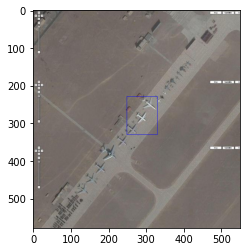

In [4]:
import matplotlib.pyplot as plt
# 设置搜索区域,左上角点为（250，130），宽为80，高为100
searchArea = (250, 230, 80, 100)
# 画出搜索区域边界,注意边界的位置。
searchAreaBoundary = (searchArea[0] - 1, searchArea[1] - 1, searchArea[2] + 2, searchArea[3] + 2)
# 将原图复制一份，在复制品上画
draw_image = match_image_origin.copy()
cv.rectangle(draw_image, searchAreaBoundary, color=(255, 0, 0))
# 用matplotlib画出，opencv不能在jupyter画出
# matplotlib彩图编码是RGB,opencv是BGR，所以要先进行颜色转换
plt.imshow(cv.cvtColor(draw_image, cv.COLOR_BGR2RGB))

### 进行匹配操作

In [6]:
matched_location = do_match_image(match_image_gary, template_image_gary, searchArea)

### 标记结果

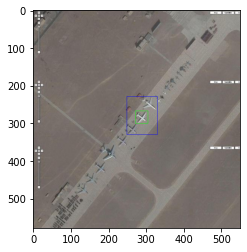

In [9]:
template_height = template_image_origin.shape[0]
template_width = template_image_origin.shape[1]

mark_boundary=(matched_location[0]-1,matched_location[1]-1,template_height+2,template_height+2)
cv.rectangle(draw_image,mark_boundary,color=(0,255,0))
plt.imshow(cv.cvtColor(draw_image, cv.COLOR_BGR2RGB))